<img src="Branded_Logo_CUDenver.PNG" width="150">

## <center>CSCI 4580/5580 - Data Science – Spring 2022</center>
<center>Assignment 2: Text Analysis, Entity Resolution, and NLP</center><center><font color='red'>Deadline: April 18, 2022 - 11:59 PM</font></center><center>Total Points: 100</center>

## Instructions
- Please note that this assignment must be done individually. By submitting this assignment, you certify that this is your own work, your code will be checked against other submissions and resources using automatic tools. Everyone should be getting a hands on experience in this course. You are free to discuss course material with fellow students, and we encourage you to use Internet resources to aid your understanding, but the work you turn in, including all code and answers, must be your own work.

## Deliverables
You need to submit a single .ipynb file on Canvas, named your-lastname_your-first-name.ipynb. For example, if your name is John Smith, you should name the file smith_john.ipynb.
- Please do not include extra files such as the input datasets in your submission.
- Answer Questions 1 - 14 in the designated cells. Please do not add or remove any cells. 
- Please download your submission file after submission and make sure it is not corrupted. Use the 'Run All' option from the 'Cell' menu to ensure all cells run without any issues. We will not be responsible for corrupted submissions and will not take a resubmission after the deadline.

## Need Help?
If you need help with this lab, please email me at sundous.hussein@ucdenver.edu or come to my office hours. We also encourage you to ask your questions on the designated channel for the assignment on Microsoft Teams. This way, you may receive assistance from your classmates that might’ve ran through the same issues.

Let's Get Started!
===

## Overview

Entity resolution is a common, yet difficult problem in data cleaning and integration.
In this assignment, we will use powerful and scalable text analysis techniques to perform entity resolution across two data sets of commercial products.

### Entity Resolution

Entity resolution, also known as record deduplication, is the process of identifying rows in one or more data sets that refer to the same real world entity.
Take an example.
You're on ebay looking for a [hip data science accessory][sliderulewiki], but you're on a budget, so you decide to scrape the [ebay listings][ebay] for a few days to get a feel for the market.
Unfortunately, the listings are confusing and you don't know how to aggregate them.
Entity resolution to the rescue!
You find an [authoritative database][sliderules] and map all the ebay listings to it.
Now you can compare shop, get that sweet Keuffel and Esser for way cheap, and impress all the data hipsters.

But finding matching records is a hard problem in general.
A major reason is that the criteria for identifying duplicates are often vague and impossible to encode in rules.
In addition, from a purely computational perspective, the problem is quadratic in the size of its inputs: naively, all pairs of records need to be compared to find all the duplicates.
In this assignment, we will begin to address both these challenges.

[sliderulewiki]: http://en.wikipedia.org/wiki/Slide_rule "Only 2X faster than Hadoop"

[sliderules]: http://www.sliderule.ca/ "Artisanal Data Technology"

[ebay]: http://www.ebay.com/sch/i.html?_odkw=keuffel+esser+slide+rule&_osacat=0&_trksid=p2045573.m570.l1313.TR0.TRC0.Xslide+rule&_nkw=slide+rule&_sacat=0&_from=R40 "Impress your colleagues"


### Application

Your assignment is to perform entity resolution over two web-scraped data sets of commercial product listings, one from Amazon, and one from Google.
The goal is to build a unified database of all products listed on the Internet: a one-stop-shop for all your shopping needs.  (Elevator pitch: *it's like **Kayak.com** for **e-commerce**!*)

The web has made unprecedented amounts of data available publicly, but scraped data frequently needs to be de-duplicated.
These data sets are typical examples of what you can collect with some simple scripting.
The data is not especially large (just a few thousand records), but even so, you will find that entity resolution is a major challenge (top results with this data are ~50% success rate).
Don't get discouraged; the goal is to get acquainted with techniques to tackle the problem, and apply them to a representative example.

### Files

Data files for this assignment:

* **Google_small.csv**, 200 records sampled from the Google data.
* **Amazon_small.csv**, 200 records sampled from the Amazon data.
* **Amazon_Google_perfectMapping.csv**, the "gold standard" mapping of duplicates.
* **stopwords.txt**, a list of common English words.

Besides the complete data files, there are "sample" data files for each data set.
Use these for **Part 1**.
In addition, there is a "gold standard" file that contains all of the true mappings between duplicate entities in the two data sets.
Every row in the gold standard file has a pair of record IDs (one Google, one Amazon) that belong to two records that describe the same thing in the real world.
We will use the gold standard to evaluate our algorithms.

## Part 0: Preliminaries
Download the data from Canvas and uncompress/unarchive it.
Read each file in from the file system, and store them in Pandas DataFrames.

For each of the data files ("Google_small.csv", "Amazon_small.csv"), we want to parse the IDs out of each record.
The IDs are the first column of the file (they are URLs for Google, and alphanumeric strings for Amazon).


In [1]:
import pandas as pd
import numpy as np
import nltk
import glob
import csv
import re

#### Question 1 [5 Points]
The two files we will use for this section are:
* Amazon_small.csv
* Google_small.csv

Each file contains the columns `id`,`name`,`description`,`manufacturer`, and `price` in this order.

**Question 1.A -** Download the data and read each of the below files into a Pandas Dataframe. The `amazon_small` variable is shown as an example.

**Question 1.B -** Set the `id` column as the index of the Dataframe for all of the files. For the "Amazon" file, the values in the `id` column are usable as-is. However, the Google file has URLs in the `id` column, which are clumsy to use as ids. Strip out the id number (the number at the end of the URL) for each value in the `id` column in the Google file and use these id numbers as the index.

In [2]:
# Question 1.A
# "Data/Amazon_small.csv --> Amazon_small.csv, had to change path to work on my machine"
amazon_small = pd.read_csv("Amazon_small.csv",encoding="latin-1",dtype=str,quotechar='"',keep_default_na=False)
google_small = pd.read_csv("Google_small.csv",encoding="latin-1",dtype=str,quotechar='"',keep_default_na=False)

**TIP:** The rsplit function splits a string into a list of string using a specified delimiter. `rsplit` starts at the end of the string, `split` starts at the front. The `maxsplit` parameter controls how many splits are performed.

**Bonus TIP:** We recommend creating a function (or using a lambda), then using the Dataframe `apply` function to apply your function over the `id` column.

In [3]:
# Example of splitting a fake URL using rsplit
my_fake_url = "http://mylegitmate.biz/files/2020/2053942"
my_fake_url_split = my_fake_url.rsplit("/",maxsplit=1)
print(my_fake_url_split)

# Last element in the list is the ID we want.
print(my_fake_url_split[-1])

['http://mylegitmate.biz/files/2020', '2053942']
2053942


In [4]:
# Question 1. B
# Set the index of amazon_small to be the "id" column
amazon_small = amazon_small.set_index("id")

# Transform the id columns of the google dataset to strip out the URL
google_small["id"] = google_small["id"].apply(lambda x: x.split("/")[-1])


# Set the index of the google datasets to be the "id" column
google_small = google_small.set_index("id")

Since all of the columns are Series containing strings, we can use the `+` operator to combine the columns together, creating a new column that is the string concatenation of the `name`, `description`, and `manufacturer` columns. This means we only need to tokenize one string per row/entry.

In [5]:
def concat_columns(series):
    return " ".join([series.title,series.description,series.manufacturer])

amazon_small["all_text"] = amazon_small.apply(concat_columns,axis=1)
google_small["all_text"] = google_small.apply(concat_columns,axis=1)

## Part 1: ER using Text Similarity

A simple approach to entity resolution is to treat all records as strings and compute their similarity with a string distance function.
In this section, we will build some components for bag-of-words text-analysis, and use them to compute record similarity.

### 1.1 Bags of Words

Bag-of-words is a conceptually simple yet powerful approach to text analysis.
The idea is to treat strings, a.k.a. **documents**, as *unordered collections* of words, or **tokens**, i.e., as bags of words.

> **Note on terminology**: "token" is more general than what we ordinarily mean by "word" and includes things like numbers, acronyms, and other exotica like word-roots and fixed-length character strings.
> Bag of words techniques all apply to any sort of token, so when we say "bag-of-words" we really mean "bag-of-tokens," strictly speaking.

Tokens become the atomic unit of text comparison.
If we want to compare two documents, we count how many tokens they share in common.
If we want to search for documents with keyword queries (this is what Google does), then we turn the keywords into tokens and find documents that contain them.

The power of this approach is that it makes string comparisons insensitive to small differences that probably do not affect meaning much, for example, punctuation and word order.



In [6]:
from nltk.tokenize import regexp_tokenize
quickbrownfox = "A quick brown fox jumps over the lazy dog."
split_regex = r'[a-zA-Z_]+'

#### Question 2 [5 points]

Implement the function `simple_tokenize(string)` that takes a string and returns a list of tokens in the string. `simple_tokenize` should split strings using the provided regular expression, and **convert the strings to lowercase**. 


**Tip:**
*The NLTK toolkit provides many functions for tokenizing words, some of which use special pre-trained models. For this question, you may use the `regexp_tokenize` function, which splits a string based on a given regular expression. You may also use python's built-in `re` library to match the regular expression if you wish.* `regexp_tokenize` will split the string, but you must perform the lowercase conversion yourself.

In [7]:
# Implement this function
def simple_tokenize(string):
    """ 
        Takes a string, transforms to lowercase & should split strings using the provided regexp.
        returns: a list of tokens in the string
    """
    # must be performed on the lowercase of the string
    string = string.lower()
    # tokenize using the regexp_tokenize function based on the given expression provided
    the_token = regexp_tokenize(string, split_regex)
    # return the tokens
    return the_token

print(simple_tokenize(quickbrownfox)) # Should give ['a', 'quick', 'brown', ... ]

# Simple testcases
assert(simple_tokenize(" ") == [])
assert(simple_tokenize(quickbrownfox) == ['a','quick','brown','fox','jumps','over','the','lazy','dog'])

['a', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog']


#### Question 3 [5 points]
Give an interpretation of what the regular expression `split_regex` is doing.

***Answer this question here:*** 
'[a-zA-Z_]+' is the regular expresion in split_regex <br>
a-z in the regex is to match single characters in the range a-z (lowercase) <br>
A-Z in the regex is to match single characters in the range A-Z (uppercase) <br>
_ in the regex is to match literally the character _ <br>
'+' in the regex is to match previous token between one and unlimited times, as many times as is needed <br>***


#### Question 4 [10 points]

Stopwords are common words that do not contribute much to the content or meaning of a document (e.g., "the", "a", "is", "to", etc.). Stopwords add noise to bag-of-words comparisons, and are usually excluded. 

Using the included file "stopwords.txt", implement tokenize, an improved tokenizer that does not emit stopwords.

You may use a method of your choosing to read in the "stopwords.txt" file (Suggested methods are Pandas `read_csv` and Python's `csv` library).

**TIP:** *We recommend converting the list of stop words to a python `set` so that you can easily test membership using the `in` operator (i.e. `x in y` returns `True` if `x` is a member of set `y`).*

In [8]:
# read in the "stopwords.txt" file using read_csv method 
# have to set header=None otherwise 'all' becomes header of the words
# crunching the list from 127 words to 126 which we do not want
stopwords = pd.read_csv("stopwords.txt",header=None)
# iloc selects list of integer values to selecet multiple rows or cols, which
# in our case is the whole series
stopwords = stopwords.iloc[:,0]
# from TIP
stopwords = set(stopwords)

# Implement this function
def tokenize(string):
    """ improved tokenizer that does not emit stopwords """
    # make sure that the string is lower just as before
    string = string.lower()
    words_in_stopwords = simple_tokenize(string)
    list_for_string = []
    # to not emit the stopwords
    for word in words_in_stopwords:
        if word not in stopwords:
            list_for_string.append(word)
    
    return list_for_string
    
print(tokenize(quickbrownfox)) # Should give ['quick', 'brown', ... ]

assert(tokenize("Why a the?") == [])
assert(tokenize(quickbrownfox) == ['quick','brown','fox','jumps','lazy','dog'])

['quick', 'brown', 'fox', 'jumps', 'lazy', 'dog']


### 1.2 Weighted Bag-of-Words: TF-IDF

Bag-of-words comparisons are not very good when all tokens are treated the same: some tokens are more important than others.
Weights give us a way to specify which tokens to favor.
With weights, when we compare documents, instead of counting common tokens, we sum up the weights of common tokens.

A good heuristic for assigning weights is called "Term-Frequency/Inverse-Document-Frequency," or TF-IDF for short.

#### TF

TF rewards tokens that appear more in the same document.
It is computed as the frequency of a token in a document, that is, if token `t` appears 5 times in document `d` then the TF of `t` in `d` is `5`. The intuition for TF is that if a word occurs often in a document, then it is more important to the meaning of the document.

#### IDF

IDF rewards tokens that are rare across the documents in a data set.
The intuition is that it is more significant if two documents share a rare word than a common one.
IDF weight for a token, *t*, in a set of documents, *U*, is computed as follows: 

* Let *N* be the total number of documents in *U*
* Find *n(t)*, the number of documents in *U* that contain *t*
* Then *IDF(t) = log(N/(1+n(t)))*.

Note we are actually using the log of the inverse document frequency, which typically works better than the raw inverse frequency. But the terminology "IDF" still applies.

#### TF-IDF

Finally, to bring it all together, the total TF-IDF weight for a token in a document is the product of its TF and IDF weights.

In this section, we will use the `TfidfVectorizer` class provided by `scikit-learn` to generate TF-IDF vectors for each of the records in both the Amazon and Google datasets. Each record $i$ will be represented by a vector of $N$ weights,
$$ x_i = [w_0,w_1,...,w_N] $$
where $N$ is the number of words in the vocabulary set. 

For example, $w_0$ represents the TF-IDF weight of the first word in the vocabulary for this document.

First, we to need choose a vocabulary for our vectors. This vocabulary should contain all of the unique words from both the Amazon and Google datasets.

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter

In [10]:
all_amazon_words = amazon_small["all_text"].apply(tokenize).sum()
all_google_words = google_small["all_text"].apply(tokenize).sum()

In [11]:
print("Total Amazon Tokens: %d" % len(all_amazon_words))
print("Total Google Tokens: %d" % len(all_google_words))

Total Amazon Tokens: 16047
Total Google Tokens: 5360


#### Question 5 [10 Points]

The two lists `all_amazon_words` and `all_google_words` are raw lists of tokens in each of the two datasets. 
Create a single python `set` called `vocab` that is the set of unique words from both lists with counts greater than 2 (i.e., if the word appears 2 or more times across both datsets, include it in the vocabulary).

In [12]:
# Create a single set() vocabulary that contains the unique words in both datasets.
# combine both raw lists of tokens from the two datasets
combined_words = all_amazon_words + all_google_words
vocab = []

word_counts = {}
# creating a dictionary of the words and occurrence rate of the words 
for word in combined_words:
    if word in word_counts:
        # if it exists, +1 occurrence to the word
        word_counts[word] += 1
    else:
        # it does not exist, add it to the dictionary with it's first occurrence
        word_counts[word] = 1
        
# iterate over the dictionary items
for key, value in word_counts.items():
    # if the value is >= 2 as prompted, add it to the vocab list
    if value >= 2:
        vocab.append(key)
        
# lastly, make it a set
vocab = set(vocab)

# Your set should contain 2563 unique words.
print(len(vocab))
assert(len(vocab) == 2563)

2563


Now we will create the `TfidfVectorizer` object. We pass in three parameters:

- `analyzer=tokenize` - This passes the `tokenize` function you made previously as a custom parser for the data.
- `vocabulary=vocab` - This passes the `vocab` custom vocabulary set to the vectorizer.
- `norm="l2"` - This sets the sample normalization to `"l2"`. This is actually the default parameter setting, but we wanted you to notice that the `TfidfVectorizer` is doing this for you (it will be important soon).

In [13]:
tfidf_vec = TfidfVectorizer(analyzer=tokenize,vocabulary=vocab,norm="l2")

Now, we need to concatenate the two dataframes together, in order to fit the vectorizer on all of the data.

In [14]:
# Combine all data for model fitting. 
# NOTE: Amazon entries are the first 200 rows (0-199), Google entries are the next 200 rows (200-399)
all_data = pd.concat([amazon_small,google_small])
all_data_tfidf = tfidf_vec.fit_transform(all_data.all_text)
all_data_tfidf

<400x2563 sparse matrix of type '<class 'numpy.float64'>'
	with 12440 stored elements in Compressed Sparse Row format>

Verify that your `all_data_tfidf` says:
```
<400x2563 sparse matrix of type '<class 'numpy.float64'>'
	with 12440 stored elements in Compressed Sparse Row format>
    ```
The sparse matrix format is a space-efficient way to store large matrices when most entries are 0. The sparse matrix only stores values for non-zero entries.

The `tfidf_vec` object also has some information about the idf weights for each of our vocabulary words, stored in `tfidf_vecidf_`, as well as a mapping between vocabulary words and vector indices stored in `tfidf_vec.vocabulary_`.

#### Question 6 [10 points]

**Question 6.A -** Use the `.idf_` member of `tfidf_vec` to plot a histogram of the idf weights. This should be an interpretable chart (i.e. Give the chart a title and label both axes).

**Question 6.B -** Use the `.idf_` and `.vocabulary_` members of `tfidf_vec` to generate a mapping between each vocabulary word and its IDF weight. Print the terms and weights for the **5 lowest** and **5 highest** IDF weights. Provide an interpretation of the meaning of these weights.

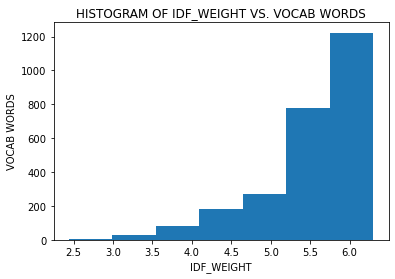

In [15]:
from matplotlib import pyplot as plt
# Question 6.A - Plot a histogram of the IDF weights. Make sure to use a title and label your axes correctly
idf_weight_vals = tfidf_vec.idf_
plt.hist(idf_weight_vals, 7)
plt.title("HISTOGRAM OF IDF_WEIGHT VS. VOCAB WORDS")
plt.xlabel("IDF_WEIGHT")
plt.ylabel("VOCAB WORDS")
plt.show()

In [16]:
# Question 6.B - Print the terms and weights for the 5 lowest and 5 highest IDF terms.
v_words = tfidf_vec.vocabulary_
# idf_weight_vals = tfidf_vec.idf_ above
# Provide an interpretation of the meaning of these weights.

# mapping vocab word to idf weight, need a dictionary then for key --> value
# then print lowest and highest 5 (this portion provided in next cell)
# let's make a list of each though to map one list to another
words_list = []
vals = []
for key, value in v_words.items():
    words_list.append(key)
    vals.append(tfidf_vec.idf_[value])
    
dict_q6b = {"word": words_list, "weight": vals}

idf_vals = pd.DataFrame(dict_q6b)
# originally was attempting to sort a dictionary, instead we should sort df by using sort_values
idf_vals = idf_vals.sort_values(by=['weight'],ascending=False)

In [17]:
print("Top 5")
print(idf_vals.iloc[:5])
print("Bottom 5")
print(idf_vals.iloc[:-6:-1])

Top 5
            word    weight
0            aaf  6.300814
1788          pz  6.300814
475   crossgrade  6.300814
472          crm  6.300814
1754     prosafe  6.300814
Bottom 5
          word    weight
2105  software  2.440085
1463       new  2.916424
803   features  2.916424
2403       use  2.933518
388   complete  2.968610



### 1.3 Cosine Similarity

Now we are ready to do text comparisons in a formal way.
The metric of string distance we will use is called **cosine similarity**.
We will treat each document as a vector in some high dimensional space.
Then, to compare two documents we compute the cosine of the angle between their two document vectors.
This is easier than it sounds.

The first question to answer is how do we represent documents as vectors?
The answer is familiar: bag-of-words!
We treat each unique token as a dimension, and treat token weights as magnitudes in their respective token dimensions.
For example, suppose we use simple counts as weights, and we want to interpret the string "Hello, world!  Goodbye, world!" as a vector.
Then in the "hello" and "goodbye" dimensions the vector has value 1, in the "world" dimension it has value 2, and it is zero in all other dimensions.

Next question is: given two vectors how do we find the cosine of the angle between them?
Recall the formula for the dot product of two vectors:

$$a \cdot b = \| a \| \| b \| \cos \theta$$

Here $a \cdot b = \sum_{i=1}^n a_i b_i$ is the ordinary dot product of two vectors, and $\|a\| = \sqrt{ \sum_{i=1}^n a_i^2 }$ is the norm of $a$.

We can rearrange terms and solve for the cosine to find it is simply the normalized dot product of the vectors.
With our vector model, the dot product and norm computations are simple functions of the bag-of-words document representations, so we now have a formal way to compute similarity:

$$similarity = \cos \theta = \frac{a \cdot b}{\|a\| \|b\|} = \frac{\sum_{i=1}^n a_i b_i}{\sqrt{\sum_{i=1}^n a_i^2} \sqrt{\sum_{i=1}^n b_i^2}}$$

Setting aside the algebra, the geometric interpretation is more intuitive.
The angle between two document vectors is small if they share many tokens in common, because they are pointing in roughly the same direction.
Then, the cosine of the angle will be large.
Otherwise, if the angle is large (and they have few words in common), the cosine is small.
So the cosine scales proportionally with our intuitive sense of similarity.

#### Question 7 [15 points]

Now that we understand cosine similarity, we can use it as a metric to determine the similarity between products in the Google and Amazon datasets.

The `all_data_tfidf` matrix contains the concatenated TF-IDF vector values for both the Amazon and Google datasets. 

Create two new variables `amazon_tfidf` and `google_tfidf` that contain only the TF-IDF vectors for the Amazon and Google data, respectively. You can perform slicing on the first dimension of `all_data_tfidf` to split the data.

Once you have `amazon_tfidf` and `google_tfidf`, calculate the pariwise cosine simialrity between the records in the two datasets. The output of this calculation should be a 200x200 matrix (200 rows in Amazon dataset x 200 rows in Google dataset). Note the formula for cosine similarity above. Store your result in a variable called `cosine_siml`.

**Note:** As mentioned previously, the vectors in `all_data_tfidf` are already L2 normalized, meaning $\| a \| \| b \| = 1$

In [18]:
# Question 7
# recommended to us use slicing recall amazong was 0-199 [:200] 
# and google was 200-399 so [200:]
amazon_tfidf = all_data_tfidf[:200]
google_tfidf = all_data_tfidf[200:]

# numpy has .dot() to perform the dot product of 2-arrays
# google_tfidf must be transposed or the dimensions won't align
cosine_siml = np.dot(amazon_tfidf, google_tfidf.T)

#### Question 8 [5 points]
Plot a heatmap of the cosine similarity matrix. Give the chart a title and axes labes, but you do not need to label the rows/columns for indivdual records (it would be very messy). Include a colorbar to show the meaning of the color scale.

**Hint:** Pyplot's `imshow` function is great for visualizing 2D matrices.

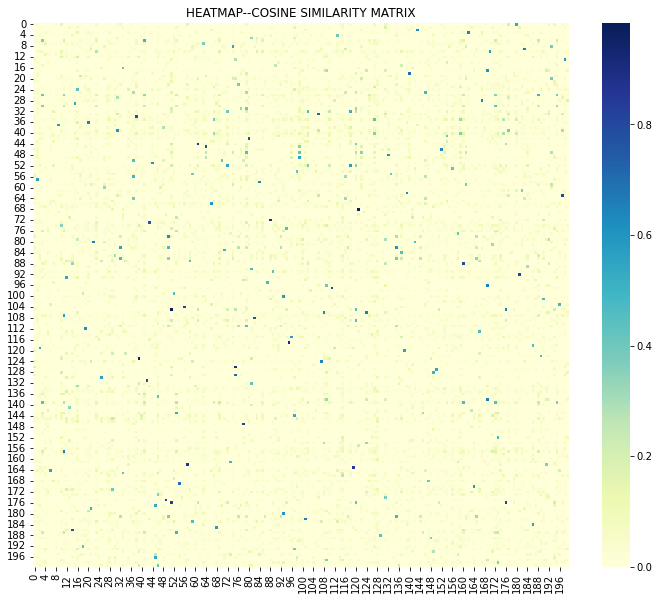

In [19]:
# Plot the heatmap here.
# need to plot the heatmap
import matplotlib.pyplot as plt
# need to import Seaborn for Python Heatmap
import seaborn as sns

plt.figure(figsize=(12,10))
plt.title("HEATMAP--COSINE SIMILARITY MATRIX")
plt.xlabel("GOOGLE")
plt.ylabel("AMAZON")
# todense() for sparse matrix
sns.heatmap(cosine_siml.todense(),cmap="YlGnBu")
plt.show()

#### Question 9 [10 points]
Now we can finally do some entity resolution! Use the `cosine_siml` matrix to build a dictionary mapping `(Amazon Id, Google Id)` tuples to their cosine similarity scores between 0 and 1.


What is the similarity between Amazon record `b000o24l3q` and Google record `17242822440574356561` ?

In [20]:
# Compute similarities
similarities = {} # dict to map
cosine_siml_matrix = cosine_siml.todense() # to dense on the sparse matrix
cosine_siml_matrix = np.array(cosine_siml_matrix) # make an np array

# index the id's (countability)
amazon_id = amazon_small.index
google_id = google_small.index

# 200 ele's in each, must be mapped to eachother as requested
for i in range(0,200):
    amaz = amazon_id[i]
    for j in range(0,200):
        goog = google_id[j]
        codes = (amaz, goog)
        similarities[codes] = cosine_siml_matrix[i][j]

print('Requested similarity is %s.' % similarities[('b000o24l3q','17242822440574356561')])

Requested similarity is 0.011360947368056326.


#### Question 10 [5 points]

Use the "gold standard" data (loaded from the supplied file `Amazon_Google_perfectMapping.csv`) to answer the following questions. How many true duplicate pairs are there in the small data sets? What is the average similarity score for true duplicates?  What about for non-duplicates?  Based on this, is cosine similarity doing a good job, qualitatively speaking, of identifying duplicates?  Why or why not?

In [21]:
# how many true dup pairs are there in the small data sets?
# what is the avg similarity score for true dups?
# what about for non-dups?
# is cosine similarity doing a good job qual. speaking of identifying dups? why or why not?
Amazon_Google_perfectMapping = pd.read_csv("Amazon_Google_perfectMapping.csv")
Amazon_Google_perfectMapping["idGoogleBase"] = Amazon_Google_perfectMapping["idGoogleBase"].apply(lambda x: x.split("/")[-1])
Amazon_Google_perfectMapping = {(x,y) for x,y in zip(list(Amazon_Google_perfectMapping['idAmazon']), 
                                                    list(Amazon_Google_perfectMapping['idGoogleBase']))}
gold_standard = set(similarities.keys())

true_dups = gold_standard.intersection(Amazon_Google_perfectMapping)
avg_sim_dups = sum([similarities[i] for i in true_dups]) / len(true_dups)
avg_sim_non = sum([similarities[i] for i in gold_standard - Amazon_Google_perfectMapping]) / len(gold_standard - Amazon_Google_perfectMapping)

print("There are %d true duplicates."% len(true_dups))
print("The average similarity of true duplicates is %f."% avg_sim_dups) 
print("And for non duplicates, it is %f."% avg_sim_non) 

There are 146 true duplicates.
The average similarity of true duplicates is 0.510057.
And for non duplicates, it is 0.013729.


## Part 2: NLP

Here we will use part of a dataset taken from Kaggle to train a sentiment analysis classifier, which is capable of predicting the positive or negative sentiment associated with a phrase. 

These data are snippets of movie reviews, which are labeled with overall sentiment of the snippet. The goal is to create a classifier which can predict the sentiment of a text sentence.

In [22]:
from nltk.sentiment import SentimentAnalyzer
from nltk.classify import NaiveBayesClassifier
from nltk.sentiment.util import mark_negation,extract_unigram_feats

#### Question 11 [5 points]

**Question 11.A -** Read the `train_reviews.csv` and `test_reviews.csv` files you downloaded from Canvas into two Pandas `Dataframe` objects called `train_df` and `test_df`. Print the first few rows of `train_df` using the `head` function (i.e. `train_df.head()`).

The sentiment labels are:

0. negative
1. somewhat negative
2. neutral
3. somewhat positive
4. positive

**Question 11.B -** Plot a histogram of each value in the `Sentiment` column for the training and testing datasets. Which labels are the most common? Make sure to give each chart a title and label the axes. 

In [23]:
# Question 11. A
train_df = pd.read_csv("train_reviews.csv")
test_df = pd.read_csv("test_reviews.csv")
print("Train_df: \n", train_df.head())
print("\n")
print("Test_df: \n", test_df.head())


Train_df: 
    PhraseId  SentenceId                                             Phrase  \
0         1           1  A series of escapades demonstrating the adage ...   
1         2           1  A series of escapades demonstrating the adage ...   
2         3           1                                           A series   
3         4           1                                                  A   
4         5           1                                             series   

   Sentiment  
0          1  
1          2  
2          2  
3          2  
4          2  


Test_df: 
    PhraseId  SentenceId                             Phrase  Sentiment
0       552          21  Best indie of the year , so far .          4
1       553          21                               Best          4
2       554          21       indie of the year , so far .          3
3       555          21         indie of the year , so far          4
4       556          21                indie of the year ,        

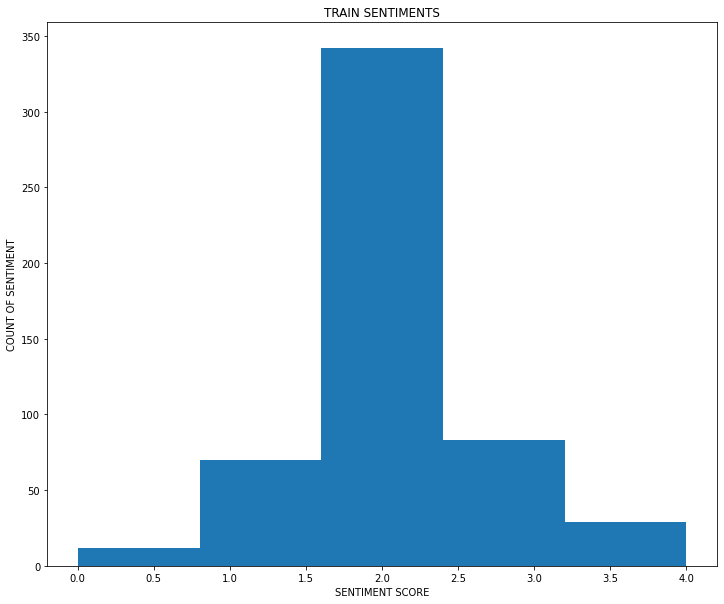

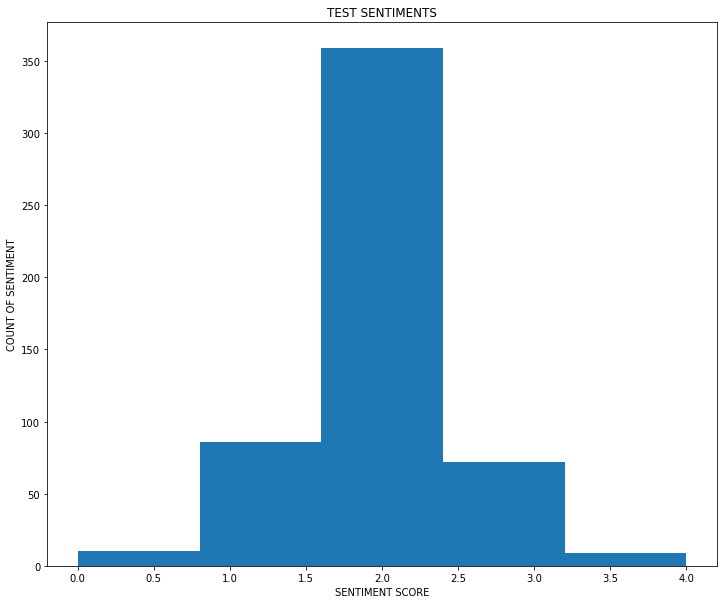

In [24]:
# Question 11. B 
# Plot a histogram of the sentiment values for all sentences.
train_sentiments = [train_df["Sentiment"]]
plt.figure(figsize=(12,10))
plt.hist(train_sentiments, 5) # 5 sentiment scores (0-4)
plt.title("TRAIN SENTIMENTS")
plt.xlabel("SENTIMENT SCORE")
plt.ylabel("COUNT OF SENTIMENT")
plt.show()

test_sentiments = [test_df["Sentiment"]]
plt.figure(figsize=(12,10))
plt.hist(test_sentiments, 5) # 5 sentiment scores (0-4)
plt.title("TEST SENTIMENTS")
plt.xlabel("SENTIMENT SCORE")
plt.ylabel("COUNT OF SENTIMENT")
plt.show()

One important part of sentiment analysis is recognizing when words are negated. For example, take the sentence:
"I enjoy running"

In [25]:
my_sent = "I enjoy running"
my_opposite_sent = "I do not enjoy running"
print(tokenize(my_sent))
print(tokenize(my_opposite_sent))

['enjoy', 'running']
['enjoy', 'running']


If we tokenize these sentences with our `tokenize` function, these sentences become indistinguishable, since we lose the context of the "not" modifier. These sentences have identical tokenized representations even though their meanings are opposite.

We need a way to note when a word appears in a *negated* context, i.e. (**not** something *vs.* something). NLTK provides us a handy function called `mark_negation` that does exactly this.

Let's try it out on our sentences above, using the `simple_tokenize` function instead of `tokenize` so that we don't drop the "don't".

In [26]:
print(mark_negation(simple_tokenize(my_sent)))
print(mark_negation(simple_tokenize(my_opposite_sent)))

['i', 'enjoy', 'running']
['i', 'do', 'not', 'enjoy_NEG', 'running_NEG']


The `mark_negation` function correctly tagged the words "enjoy" and "running" with a `_NEG` suffix, to indicate that they are used in a negative context.

#### Question 12 [5 points]
In both `train_df` and `test_df` the `Phrase` column holds a string which we need to tokenize. Thankfully, you have already created two tokenize functions in the previous part of this assignment! For this we do *not* want to remove stop words, so use `simple_tokenize`. 


**Question 12.A -** Create a new column called `tokens` in both `train_df` and `test_df` which contain the tokenized representation (i.e. a list of strings) for the `Phrase` column. Use the `mark_negation` function to ensure that negations are tagged correctly.

**Question 12.B -** Create a set called `unique_words` containing the unique words in the `tokens` column from both `train_df` and `test_df` (i.e. create a single set).

In [27]:
# Question 12. A
train_df["tokens"] = train_df["Phrase"].apply(lambda x: mark_negation(simple_tokenize(x)))
test_df["tokens"] = test_df["Phrase"].apply(lambda x: mark_negation(simple_tokenize(x)))
print(train_df.head())
print("\n")
print(test_df.head())

   PhraseId  SentenceId                                             Phrase  \
0         1           1  A series of escapades demonstrating the adage ...   
1         2           1  A series of escapades demonstrating the adage ...   
2         3           1                                           A series   
3         4           1                                                  A   
4         5           1                                             series   

   Sentiment                                             tokens  
0          1  [a, series, of, escapades, demonstrating, the,...  
1          2  [a, series, of, escapades, demonstrating, the,...  
2          2                                        [a, series]  
3          2                                                [a]  
4          2                                           [series]  


   PhraseId  SentenceId                             Phrase  Sentiment  \
0       552          21  Best indie of the year , so far .  

Verify that your `tokens` column looks correct. (i.e., it should be a list of lowercase strings corresponding to the words in `Sentiment`)

In [28]:
# Question 12. B
# Add all of the unique words in train_df
unique_words = set()
for token_group in train_df.tokens:
    for token in token_group:
        token = token.lower() # just making sure they are lowercase tokens
        unique_words.add(token) # add it to the unique words set

# Do the same for test_df.
for token_group in test_df.tokens:
    for token in token_group:
        token = token.lower() # just making sure they are lowercase tokens
        unique_words.add(token) # add it to the unique words set
        
len(unique_words) #to test it is 414, assertion had no issue as well

414

In [29]:
# Should have 414 unique words
assert(len(unique_words) == 414)

Now we can create a `SentimentAnalyzer`, which is an NLTK helper class for building a sentiment analyzer.

In [30]:
analyzer = SentimentAnalyzer()

#### Question 13 [5 points]
The sentiment analyzer that we will train expects to recieve each phrase as a tuple in the form of:
`(["a","series","of","tokens"],label)`

Build two variables `train_set` and `test_set` containing lists of tuples of the form shown above by combining the `tokens` and `Sentiment` columns from each dataframe.

`train_set`  and `test_set` should both look like a list of tuples containing the token list and label:
```
[
...
(['of',
  'escapades',
  'demonstrating',
  'the',
  'adage',
  'that',
  'what',
  'is',
  'good',
  'for',
  'the',
  'goose'],2),
...
]
```

In [31]:
# Question 13
train_set = [(tokens, Sentiment) for tokens, Sentiment in zip(train_df.tokens, train_df.Sentiment)]
test_set = [(tokens, Sentiment) for tokens, Sentiment in zip(test_df.tokens, test_df.Sentiment)]

We can now use the `add_feature_extractor` function to create a feature extractor for our dataset. In this case, we will use `extract_unigram_feats`, which will provide a boolean indicator of whether each word in `unique_words` exists in the current sentence

In [32]:
analyzer.add_feat_extractor(extract_unigram_feats,unigrams=unique_words)

Now we can create two sets of features `train_features` and `test_features` for our training and testing data respectively.

In [33]:
train_features = analyzer.apply_features(train_set)
test_features = analyzer.apply_features(test_set)

We will learn more about using classifiers such as Naive Bayes in the next assignment. For now, let's just use the NaiveBayesClassifier to perform sentiment analysis.

This cell may take a few minutes to run while it is training the classifier.

In [34]:
nb_trainer = NaiveBayesClassifier.train
nb_classifier = analyzer.train(nb_trainer,train_features)

Training classifier


In [35]:
analyze_dict = analyzer.evaluate(test_features)

Evaluating NaiveBayesClassifier results...


In [36]:
from seaborn import color_palette
formatted_vals = {re.match("([a-zA-Z\-]+)(?:\s+\[(\d+)\])?",key).groups():[val] for key,val in analyze_dict.items()}
pretty_df = pd.DataFrame(formatted_vals).transpose().sort_index()
pretty_df.columns = ["Value"]
pretty_df.index.set_names(["Metric","Class"],inplace=True)
pretty_df.style.background_gradient(cmap="Greens")

#### Question 14 [5 points]
Now that we have trained our classifier, we can evaluate it on our testing set.

Provide an interpretation of the class results as printed above. Does the classifier do well in general?
Which classes does the classifier have an easier time predicting? 

The class labels are:
0. negative
1. somewhat negative
2. neutral
3. somewhat positive
4. positive

In [37]:
# Question 14

# Interpretation of the class results printed above shows that the classifier
# accuracy settled around 0.539... which in my opinion should be taken heavily into consideration when using this
# which was essentially stated at the beginning of the document, so good job there.

# Upon further analysis though we can see that class2 had the highest values meaning
# that the classifier perhaps had an easier time prediciting for class2, all a bove 73% for each metric.

# Overall, many might say that the classifier did not do well in general, but again
# as stated a ~ of 50% success rate due to entity resolution being difficult in nature was what we were aiming for
# and for that reason we trained our classifier and I would give it a neutral (not good, not bad) score

Done! Save and submit your notebook on Canvas!